<a href="https://colab.research.google.com/github/plaban1981/Hugging_Face_transformers_topics/blob/main/BERT_Fine_Tuning_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Fine-Tuning NER Tutorial with PyTorch

By Chris McCormick and Nick Ryan

In this tutorial I'll show you how to use BERT with the huggingface PyTorch library to quickly and efficiently fine-tune a model to get near state of the art performance in named entity recognition (NER from here on out.) 

NER is a widely used NLP task that tries to locate and classify the names and entities contained in a piece of text, commonly things like people, organizations, locations, etc. In this tutorial we'll be training our NER model to look at a dataset of short restaurant-related reviews and queries and identify things like dishes, restaurant names, and prices. If you're following along with your own dataset, as long as your processed inputs resemble ours you'll be able to run the fine-tune the model in the same fashion.

## Notebook Access


-------------------------------------

[![Notebook Access](https://drive.google.com/uc?export=view&id=1yPJapK5X9kXLDhtuDJm3Hw4-ZlxMwcsa)](https://www.chrismccormick.ai/membership)

<sup>\*</sup>Notify me [here](team@chrismccormick.ai)

<sup>\*\*</sup>Join my site [here](https://www.chrismccormick.ai/membership) 

---------------------------------------



# Introduction

Since we'll be focusing on NER fine-tuning and for the sake of legibility, I won't go into great detail about BERT in general or the broader process of language model fine-tuning. We've covered these topics in our free [BERT fine-tuning tutorial](http://mccormickml.com/2019/07/22/BERT-fine-tuning/) in detail here, so if you're curious or some of the code isn't immediately obvious I encourage you to take a look.

In general, fine-tuning BERT or another language model with your dataset will yield very good results and requires less data than from-scratch models. However this comes at the cost of having to train it yourself and, more importantly, possibly at the cost of making a large transformer-sized model work quickly in a development setting (buying GPUs). In some cases, using existing NLP libraries with off-the-shelf NER models might be to your benefit, so look for the [related post](http://mccormickml.com/2020/05/19/existing-ner-tools/) providing some resources and tips on using existing NER models.

# 1. Setup

## 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


## 1.2. Installing the Hugging Face Library


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.8MB 5.7MB/s 
     |████████████████████████████████| 2.9MB 19.5MB/s 
     |████████████████████████████████| 890kB 34.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=0bda8e775041a7cfc45d1fdff97f581f356769fb6d18adcd98ccd0a4d6a64102
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# 2. Loading the MIT Restaurant Dataset


## 2.1. Download

We'll use the `wget` package to download the dataset to the Colab instance's file system. 

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=3f1f1a8233d643eb66691b89be6eea7b94e410efcff57c1cb98c53e12e3de204
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


The test and train dataset is here: https://groups.csail.mit.edu/sls/downloads/restaurant/

In [ ]:
import wget
import os

print('Downloading dataset...')

# The URL for the *training* examples.
url = 'https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttrain.bio'

# Download the file (if we haven't already)
#if not os.path.exists('./restauranttrain.bio'):
wget.download(url, './restauranttrain.bio')

# The URL for the *test* examples.
url = 'https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttest.bio'

# Download the file (if we haven't already)
#if not os.path.exists('./restauranttest.bio'):
wget.download(url, './restauranttest.bio')

'./restauranttest.bio'

## 2.2. NER Tags and IOB Format

Both the train and test datasets are single files containing restaurant-related text (mostly reviews and queries), where each word has a NER tag specifying it as one of the following restaurant-related entities:

- Amenity
- Cuisine
- Dish
- Hours
- Location
- Price
- Rating
- Restaurant_Name


The NER tag follows a special format used widely in NER literature called the [IOB format](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)#:~:text=) (Inside, Outside, Beginning Format). This format gives us a way to not only tag entities, but to indicate which words are part of the same entity:

- **O**: this tag means the word is not part of an entity.
- **B**: this tag means the word is either a single-word entity name, or else the first word in a multi-word entity name.
- **I**: this tag means the word is part of a multi-word entity, but is not the first word in the full entity name.

For example:

| TAG | WORD  |
|---|---|
| O  | My  |
| O  | first  |
| O  |  name |
| O  |  is |
| B-Person  | John  |
|  O | and  |
| O  | my  |
| O  | full  |
| O  |  name |
| O  |  is |
| B-Person  | John  |
| I-Person  | A.  |
| I-Person  | Smith  |

Furthermore, as you can see above the **B** and **I** tags are used as prefixes before the entity types and can be used before any entity type you like, whether it's people or restaurants or countries. There are some variations of the IOB format that might use special tags for single-word entities or tags for words that are the last word in a multi-word entity. Different formats might confer small advantages on different kinds of datasets, but for now there's no need to worry if you're working on a dataset with a different tag format (as long as you are consistent!) 

Now, back to our dataset. The words in each review are separated by line, and reviews themselves are separated by blank lines. Each line that is not blank contains a word from the review and its NER tag:

| TAG | WORD  |
|---|---|
|  O | a   |
|  B-Rating | four  |
| I-Rating | star  |
|  O |  restaurant |
| B-Location  | with  |
| I-Location  | a  |
| B-Amenity  | bar  |
|    |    |
| O  | any  |
|  B-Cuisine |  bbq |
| O  | places  |
|  B-Hours | open  |
| I-Hours  | before  |
| I-Hours  | 5  |
|  B-Location |  nearby |



## 2.3. Parse Dataset


I couldn't find anything to quickly parse the .bio file format found here, so we'll need to do some quick processing to get our data into the desired format for fine-tuning.

In [ ]:
import csv

# List of all sentences in the dataset.
sentences = []
labels = []

# Lists to store the current sentence.
tokens = []
token_labels = []

# Gather the set of unique labels.
unique_labels = set()

# Read the dataset line by line. Each line of the file
# is either empty or has two tokens, separated by a tab.
with open("./restauranttrain.bio", newline = '') as lines:                                                                                          
    
    # Use the `csv` class to split the lines on the tab character.
    line_reader = csv.reader(lines, delimiter='\t')
    
    # For each line in the file...
    for line in line_reader:
        
        # If we encounter a blank line, it means we've completed the previous 
        # sentence. 
        if line == []:

            # Add the completed sentence.
            sentences.append(tokens)
            labels.append(token_labels)           
    
            # Start a new sentence.
            tokens = []
            token_labels = []        

        else: 
            # Add the token and its label to the current sentence.
            tokens.append(line[1])
            token_labels.append(line[0])

            # Add the label to the set (no effect if it already exists).
            unique_labels.add(line[0])
        


Here are all of the unique labels in the dataset.

In [ ]:
unique_labels

{'B-Amenity',
 'B-Cuisine',
 'B-Dish',
 'B-Hours',
 'B-Location',
 'B-Price',
 'B-Rating',
 'B-Restaurant_Name',
 'I-Amenity',
 'I-Cuisine',
 'I-Dish',
 'I-Hours',
 'I-Location',
 'I-Price',
 'I-Rating',
 'I-Restaurant_Name',
 'O'}

In [ ]:
# Map each unique label to an integer.
label_map = {}

# For each label...
for (i, label) in enumerate(unique_labels):
    
    # Map it to its integer.
    label_map[label] = i

Now we have our data separated into:
- **sentences** containing a list of tokenized sentences
- **labels** containing a list of corresponding IOB

**If you have you are using this tutorial to fine-tune BERT on your own dataset, make sure to format your input data in the same way.**

In [ ]:
print("Number of training sentences: {:,}".format(len(sentences)))

Number of training sentences: 7,660


Let's look at a random sentence as an example.

In [ ]:
print("Example sentence:")
print ("    Tokens:", sentences[4])
print ("    Labels:", labels[4])

print ('\nSentence Tokens and Labels:')
for i in zip(sentences[4], labels[4]):
  print (i)

Example sentence:
    Tokens: ['a', 'great', 'lunch', 'spot', 'but', 'open', 'till', '2', 'a', 'm', 'passims', 'kitchen']
    Labels: ['O', 'O', 'O', 'O', 'O', 'B-Hours', 'I-Hours', 'I-Hours', 'I-Hours', 'I-Hours', 'B-Restaurant_Name', 'I-Restaurant_Name']

Sentence Tokens and Labels:
('a', 'O')
('great', 'O')
('lunch', 'O')
('spot', 'O')
('but', 'O')
('open', 'B-Hours')
('till', 'I-Hours')
('2', 'I-Hours')
('a', 'I-Hours')
('m', 'I-Hours')
('passims', 'B-Restaurant_Name')
('kitchen', 'I-Restaurant_Name')


We also have a **label_map** dictionary that will map our tags to integers during the fine-tuning process:

In [ ]:
label_map

{'B-Amenity': 4,
 'B-Cuisine': 13,
 'B-Dish': 9,
 'B-Hours': 2,
 'B-Location': 5,
 'B-Price': 8,
 'B-Rating': 6,
 'B-Restaurant_Name': 16,
 'I-Amenity': 3,
 'I-Cuisine': 15,
 'I-Dish': 10,
 'I-Hours': 0,
 'I-Location': 12,
 'I-Price': 14,
 'I-Rating': 1,
 'I-Restaurant_Name': 7,
 'O': 11}

# 3. Tokenization & Input Formatting

The dataset comes already “tokenized” in the sense that it’s split into lists of words.

There is still more processing of the text to be done before we can send these sentences through BERT, though.

Here's what needs to happen:

1. The words need to be mapped to their IDs in the BERT vocabulary.
2. For words that aren't in the BERT vocabulary, the tokenizer will break these down into subwords.
3. BERT requires that we prepend the special `[CLS]` token to the beginning of every sentence, and append the `[SEP]` token to the end.
4. To support batch processing of the inputs, all of the sentences should be padded out (with the special `[PAD]` token) to the same length. 
    * This, in turn, requires us to provide "attention masks" to prevent BERT from actually looking at the `[PAD]` tokens for meaning.

Because all of the above steps are common to many applications of BERT, the BertTokenizer class in the Transformers library has a help function named `encode_plus` which will handle all of the above tasks for us.

> *Side Note: Do you see a problem here? The tokenizer is going to screw up our token labels! We'll address this in section 3.3.*

First, though, we need to pick a maximum sentence length to pad all of the sentences to.


## 3.1. Max Length

Let's measure the length of all of the sentences and look at the distribution of lengths in order to choose a sensible "max_len" value for padding our sentences to.

In [ ]:
from transformers import BertTokenizer
import numpy as np

# We'll need the BertTokenizer in order to determine the number of tokens in
# the sentences *according to BERT*.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Record the length of each sequence.
lengths = []

print('Measuring sentence lengths...')

# For every sentence...
for sen in sentences:

    # Reconstruct the sentence to let BERT decide how to tokenize it.
    sen = ' '.join(sen)

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Record the length of the sentence after tokenization.
    lengths.append(len(encoded_sent))

print('    DONE.')


Measuring sentence lengths...
    DONE.


Let's grab some quick statistics--what are the min, max and median comment lenghts?

In [ ]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(int(np.median(lengths))))

   Min length: 3 tokens
   Max length: 39 tokens
Median length: 11 tokens


To further analyze it, let's plot the distribution. 


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# of Sentences')

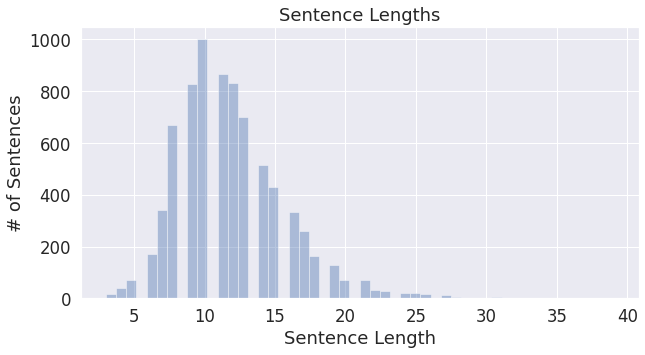

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.distplot(lengths, kde=False, rug=False)

plt.title('Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('# of Sentences')


These are some very short sentences!

Since we don't know what the longest sentence in the test set is, let's set the max_len to 50 to leave some room (the maximum training sentence length was 39 tokens).

## 3.2. Re-Tokenize with BERT

Now we're ready to perform the real tokenization! 

> *Note that, to allow the BERT tokenizer to split "unknown" words into subwords, we're actually going to  reconstruct each sentence (by combining the tokens with white space) before feeding it to the tokenizer.*

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split unknown words into subwords.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length (we chose 50).
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens (so that the self-attention mechanism in BERT ignores the `[PAD]` tokens).


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:

    # Reconstruct the sentence--otherwise `tokenizer` will interpret the list
    # of string tokens as having already been tokenized by BERT.
    sent_str = ' '.join(sent)

    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent_str,                  # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = 50,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'][0])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'][0])

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Masks:', attention_masks[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  ['2', 'start', 'restaurants', 'with', 'inside', 'dining']
Token IDs: tensor([ 101, 1016, 2707, 7884, 2007, 2503, 7759,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


## 3.3. Add Null Labels

We've prepared all of our sentences to feed into BERT, but there's a problem--we've added a bunch of tokens to the input sequences (special tokens, padding, and splitting "unknown" words) and now *the original token labels are no longer aligned with the tokens!*

To fix this, we'll define an additional token label that we'll give to any tokens that were added. You might call this the "null" label, or the "padding" label. 

So, for example if our sentence is "5 star resturants nearby with chorizo tacos," the words "resturants," "chorizo," and "tacos" all get tokenized into smaller subwords and need new labels:
![](https://drive.google.com/uc?id=1TnGVa13ufIq3Yu0v-eNuYH1BZaqcym-z)


We add null labels to each of the subsequent subword tokens and the result is the newly tokenized sentence that looks like this:


![](https://drive.google.com/uc?id=1YIMz23PbdzhYrBmzsICvLE-deuzgFRdK)

Our `label_map` dictionary, which we created while parsing the dataset, maps the token *label* strings to unique integer IDs. We'll add to this the integer ID `-100` to label any of these "added" tokens.

The following cell will update the list of token labels for each sentence by adding in the null label where needed.

In [ ]:
# New labels for all of the input sentences.
new_labels = []

# The special label ID we'll give to "extra" tokens.
null_label_id = -100

# For each sentence...
for (sen, orig_labels) in zip(input_ids, labels):
    
    # Create a new list to hold the adjusted labels for this sentence.
    padded_labels = []

    # This will be our index into the original label list.
    orig_labels_i = 0 

    # For each token in the padded sentence...
    for token_id in sen:

        # Pull the value out of the tensor.
        token_id = token_id.numpy().item()

        # If `[PAD]`, `[CLS]`, or `[SEP]`...
        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):
            
            # Assign it the null label.
            padded_labels.append(null_label_id)

        # If the token string starts with "##"...
        elif tokenizer.ids_to_tokens[token_id][0:2] == '##':

            # It's a subword token, and not part of the original dataset, so
            # assign it the null label.
            padded_labels.append(null_label_id)

        # If it's not any of the above...
        else:
            
            # This token corresponds to one of the original ones, so assign it
            # it's original label.

            # Look up the label for this token.
            label_str = orig_labels[orig_labels_i]

            # Map the label to its ID, and assign it.
            padded_labels.append(label_map[label_str])

            # Increment our index into the original labels list.
            orig_labels_i += 1

    # If we did this right, then the new `padded_labels` list should match
    # the length of the tokenized sentence.
    assert(len(sen) == len(padded_labels))    

    # Store the updated labels list for this sentence.
    new_labels.append(padded_labels)


Now, when we look at a real example sentence from our dataset we can see the result of these changes:

"5 star resturants in my town"

This sentence, like the one above, includes a misspelling of the word 'restaurant', so the BERT tokenizer splits this word into multiple subwords. 

The first subword `rest` is given the original label, while `##ura` and `##nts` are labeled with ID `-100`.


In [ ]:
print('\nSentence:    ', sentences[2])
print('\nLabels:      ', labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[2])))
print('\nToken IDs:   ', input_ids[2])
print('\nNew Labels:  ', new_labels[2])
print('\nMask:        ', attention_masks[2])



Sentence:     ['5', 'star', 'resturants', 'in', 'my', 'town']

Labels:       ['B-Rating', 'I-Rating', 'O', 'B-Location', 'I-Location', 'I-Location']

BERT Tokens:  ['5', 'star', 'rest', '##ura', '##nts', 'in', 'my', 'town']

Token IDs:    tensor([ 101, 1019, 2732, 2717, 4648, 7666, 1999, 2026, 2237,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])

New Labels:   [-100, 6, 1, 11, -100, -100, 5, 12, 12, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]

Mask:         tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 

Finally, this cell turns our Python lists into Pytorch tensors.

In [ ]:
# Convert the lists into PyTorch tensors.

# `input_ids` is a list of tensor arrays--stack them into a matrix with size
# [7,660  x  50].
pt_input_ids = torch.stack(input_ids, dim=0)

# `attention_masks` is a list of tensor arrays--stack them into a matrix with
# size [7,660  x  50].
pt_attention_masks = torch.stack(attention_masks, dim=0)

# Labels is a list of lists. Convert it into a tensor matrix with size 
# [7,660  x  50].
pt_labels = torch.tensor(new_labels, dtype=torch.long)

## 3.4. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,894 training samples
  766 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. BertForTokenClassification

We'll be using BertForTokenClassification. This is the normal BERT model with an added single linear layer that is used for classification of each token's entity class. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.



In [ ]:
# This is the number of labels in our dataset, so we will be doing 18-way classification (all labels plus our padding label)
len(label_map)

17

In [ ]:
from transformers import BertForTokenClassification, AdamW, BertConfig

# Load BertForTokenClassification 
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(label_map) + 1, # The number of output labels--18 for our NER dataset
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

## 4.2. Optimizer & Learning Rate Scheduler

In [ ]:
# Load the AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate 
                  eps = 1e-8 # args.adam_epsilon 
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs 
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Helper function for formatting elapsed times.


In [ ]:
import time
import numpy as np
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertfortokenclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.TokenClassifierOutput
        result = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = result.loss

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    216.    Elapsed: 0:00:05.
  Batch    80  of    216.    Elapsed: 0:00:10.
  Batch   120  of    216.    Elapsed: 0:00:14.
  Batch   160  of    216.    Elapsed: 0:00:20.
  Batch   200  of    216.    Elapsed: 0:00:24.

  Average training loss: 0.50
  Training epcoh took: 0:00:26

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    216.    Elapsed: 0:00:05.
  Batch    80  of    216.    Elapsed: 0:00:10.
  Batch   120  of    216.    Elapsed: 0:00:14.
  Batch   160  of    216.    Elapsed: 0:00:19.
  Batch   200  of    216.    Elapsed: 0:00:24.

  Average training loss: 0.24
  Training epcoh took: 0:00:26

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    216.    Elapsed: 0:00:05.
  Batch    80  of    216.    Elapsed: 0:00:10.
  Batch   120  of    216.    Elapsed: 0:00:14.
  Batch   160  of    216.    Elapsed: 0:00:19.
  Batch   200  of    216.    Elapsed: 0:00:24.

  Average training loss: 0.17
  Training 

Let's take a look at our training loss over all batches:

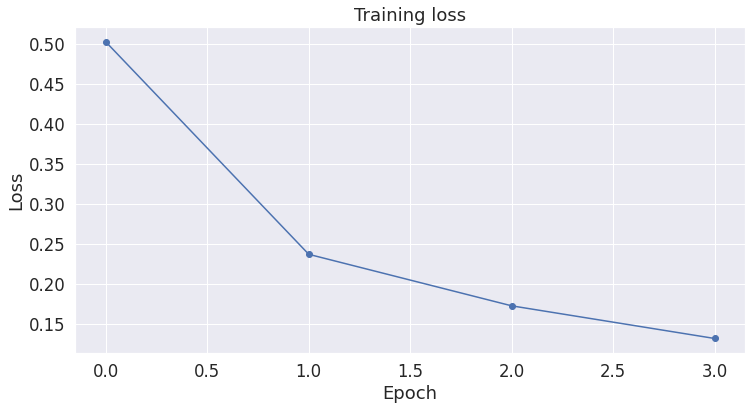

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using F1 score because this is the metric used for CONLL2003 and other NER datasets, and gives an intuitive understanding of model performance.

When we evaluate performance we only pay attention to predictions for the non-pad tokens, so first remove all pad tokens before calculating the F1 score.

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

**Step 1: Parse Dataset File**

Read in the test set file "./restauranttest.bio" and extract the test samples from it.

In [ ]:
import csv

# List of all sentences in the dataset.
sentences = []
labels = []

# Lists to store the current sentence.
tokens = []
token_labels = []

# Gather the set of unique labels.
unique_labels = set()

# Read the dataset line by line. Each line of the file
# is either empty or has two tokens, separated by a tab.
with open("./restauranttest.bio", newline = '') as lines:                                                                                          
    
    # Use the `csv` class to split the lines on the tab character.
    line_reader = csv.reader(lines, delimiter='\t')
    
    # For each line in the file...
    for line in line_reader:
        
        # If we encounter a blank line, it means we've completed the previous 
        # sentence. 
        if line == []:

            # Add the completed sentence.
            sentences.append(tokens)
            labels.append(token_labels)           
    
            # Start a new sentence.
            tokens = []
            token_labels = []        

        else: 
            # Add the token and its label to the current sentence.
            tokens.append(line[1])
            token_labels.append(line[0])

            # Add the label to the set (no effect if it already exists).
            unique_labels.add(line[0])
        


**Step 2: Re-Tokenize with BERT**

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split unknown words into subwords.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens (so that the self-attention mechanism in BERT ignores the `[PAD]` tokens).


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:

    # Reconstruct the sentence--otherwise `tokenizer` will interpret the list
    # of string tokens as having already been tokenized by BERT.
    sent_str = ' '.join(sent)

    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent_str,                  # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 50,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'][0])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'][0])

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Masks:', attention_masks[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  ['a', 'four', 'star', 'restaurant', 'with', 'a', 'bar']
Token IDs: tensor([ 101, 1037, 2176, 2732, 4825, 2007, 1037, 3347,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


**Step 3: Add Null Labels**

Add in the null label for all tokens added by the BERT tokenizer.

In [ ]:
# New labels for all of the input sentences.
new_labels = []

# The special label ID we'll give to "extra" tokens.
null_label_id = -100

# For each sentence...
for (sen, orig_labels) in zip(input_ids, labels):
    
    # Create a new list to hold the adjusted labels for this sentence.
    padded_labels = []

    # This will be our index into the original label list.
    orig_labels_i = 0 

    # For each token in the padded sentence...
    for token_id in sen:
        
        # Pull the value out of the tensor.
        token_id = token_id.numpy().item()

        # If `[PAD]`, `[CLS]`, or `[SEP]`...
        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):
            
            # Assign it the null label.
            padded_labels.append(null_label_id)

        # If the token string starts with "##"...
        elif tokenizer.ids_to_tokens[token_id][0:2] == '##':

            # It's a subword token, and not part of the original dataset, so
            # assign it the null label.
            padded_labels.append(null_label_id)

        # If it's not any of the above...
        else:
            
            # This token corresponds to one of the original ones, so assign it
            # it's original label.

            # Look up the label for this token.
            label_str = orig_labels[orig_labels_i]

            # Map the label to its ID, and assign it.
            padded_labels.append(label_map[label_str])

            # Increment our index into the original labels list.
            orig_labels_i += 1

    # If we did this right, then the new `padded_labels` list should match
    # the length of the tokenized sentence.
    assert(len(sen) == len(padded_labels))    

    # Store the updated labels list for this sentence.
    new_labels.append(padded_labels)


Let's look at an example sentence to see the results of all of our changes.


In [ ]:
print('\nSentence:    ', sentences[2])
print('\nLabels:      ', labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[2])))
print('\nToken IDs:   ', input_ids[2])
print('\nMask:        ', attention_masks[2])
print('\nNew Labels:  ', new_labels[2])


Sentence:     ['any', 'bbq', 'places', 'open', 'before', '5', 'nearby']

Labels:       ['O', 'B-Cuisine', 'O', 'B-Hours', 'I-Hours', 'I-Hours', 'B-Location']

BERT Tokens:  ['any', 'bb', '##q', 'places', 'open', 'before', '5', 'nearby']

Token IDs:    tensor([  101,  2151, 22861,  4160,  3182,  2330,  2077,  1019,  3518,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

Mask:         tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

New Labels:   [-100, 11, 13, -100, 11, 2, 0, 0, 5, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 

**Step 4: Setup DataLoader**

In [ ]:
# Convert the lists into PyTorch tensors.

# `input_ids` is a list of tensor arrays--stack them into a matrix.
pt_input_ids = torch.stack(input_ids, dim=0)

# `attention_masks` is a list of tensor arrays--stack them into a matrix.
pt_attention_masks = torch.stack(attention_masks, dim=0)

# Labels is a list of lists. Convert it into a tensor matrix.
pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [ ]:
# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(pt_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      result = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,521 test sentences...
    DONE.


Now we can score the predictions. 

First, we need to do some reshaping of our results.

In [ ]:
from sklearn.metrics import f1_score

# First, combine the results across the batches.
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)

print("After flattening the batches, the predictions have shape:")
print("    ", all_predictions.shape)

# Next, let's remove the third dimension (axis 2), which has the scores
# for all 18 labels. 

# For each token, pick the label with the highest score.
predicted_label_ids = np.argmax(all_predictions, axis=2)

print("\nAfter choosing the highest scoring label for each token:")
print("    ", predicted_label_ids.shape) 

# Finally, for the sake of scoring, we don't actually care about the different
# sentences--we just look at whether the model made correct predictions for the
# individual tokens.

# Eliminate axis 0, which corresponds to the sentences.
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

print("\nAfter flattening the sentences, we have predictions:")
print("    ", predicted_label_ids.shape)
print("and ground truth:")
print("    ", all_true_labels.shape)


After flattening the batches, the predictions have shape:
     (1521, 50, 18)

After choosing the highest scoring label for each token:
     (1521, 50)

After flattening the sentences, we have predictions:
     (76050,)
and ground truth:
     (76050,)


Before we score the predictions, we want to remove all of the tokens labeled `null`, since we don't care about these.

This is ok because, in a real NER system, you would:
1. Ignore the predictions for the special tokens (`[CLS]`, `[SEP]`, and `[PAD]`)
2. Use the prediction for the first subword for any broken-apart words.

In [ ]:
# Construct new lists of predictions which don't include any null tokens.
real_token_predictions = []
real_token_labels = []

# For each of the input tokens in the dataset...
for i in range(len(all_true_labels)):

    # If it's not a token with a null label...
    if not all_true_labels[i] == -100:
        
        # Add the prediction and the ground truth to their lists.
        real_token_predictions.append(predicted_label_ids[i])
        real_token_labels.append(all_true_labels[i])

print("Before filtering out `null` tokens, length = {:,}".format(len(all_true_labels)))
print(" After filtering out `null` tokens, length = {:,}".format(len(real_token_labels)))


Before filtering out `null` tokens, length = 76,050
 After filtering out `null` tokens, length = 14,256


The last step is to compute the F1 score!

In [ ]:
from sklearn.metrics import f1_score

# Calculate the F1 score. Because this is a multi-class problem, we have
# to set the `average` parameter. TODO - What does `micro` do?
f1 = f1_score(real_token_labels, real_token_predictions, average='micro') 

print ("F1 score: {:.2%}".format(f1))

F1 score: 91.98%


For reference, [this paper](https://www.aclweb.org/anthology/W18-5711.pdf) from 2018 benchmarked the F1 score at around 79. 

# Conclusion

We've seen here that by fine-tuning BERT you can quickly create a high quality NER model with minimal effort and training time.

# Appendix


## A1. Saving & Loading Fine-Tuned Model

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

Let's check out the file sizes, out of curiosity.

In [ ]:
!ls -l --block-size=K ./model_save/

total 425740K
-rw-r--r-- 1 root root      2K Feb  2 23:30 config.json
-rw-r--r-- 1 root root 425497K Feb  2 23:30 pytorch_model.bin
-rw-r--r-- 1 root root      1K Feb  2 23:30 special_tokens_map.json
-rw-r--r-- 1 root root      1K Feb  2 23:30 tokenizer_config.json
-rw-r--r-- 1 root root    227K Feb  2 23:30 vocab.txt


The largest file is the model weights, at around 418 megabytes.

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 416M Feb  2 23:30 ./model_save/pytorch_model.bin


To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/Shared drives/ChrisMcCormick.AI/Blog Posts/BERT Fine-Tuning/"

The following functions will load the model back from disk.

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

# Change Log

**2021-02-02**
* Updated all calls to model (fine-tuning and evaluation) to use the `TokenClassifierOutput` class for return values.
